# ME 696 Homework 3

## Particle Filter on a Linear-Gaussian System 

In this exercise,  you are asked to design a particle filter for a simple dynamical system: a car with linear dynamics moving in a linear environment.  Assume $\Delta t=1$ for simplicity.  The position of the car at time $t$ is given by $x$.  Its velocity is $\dot{x}_t$, and its acceleration is $\ddot{x}_t$.  Suppose the acceleration is set randomly at each point in time, according to a Gaussian with zero mean and covariance $\sigma^2=1$.

(a)  What is a minimal state vector for the particle filter such that the resulting system is Markovian? 

(b)  For your state vector, design the state transition probability $p(x_t|u_t,x_{t−1})$. *Hint:  This transition function will possess linear matrices $A$ and $B$ and a noise covariance $R$*.

(c) Implement the state prediction step of the particle filter in your programming language of choice.
Assuming we know at time $t = 0$, $x_0 = \dot{x}_0 = \ddot{x}_0 = 0$. Plot the state distributions for times
$t = 1,2,\dots,5$.

(d) For each value of $t$, plot the joint posterior over $x$ and $\dot{x}$ where $x$ is the horizontal axis and $\dot{x}$ is the vertical axis. For each posterior, you are asked to plot an uncertainty ellipse, which is the
ellipse of points that are one standard deviation away from the mean.

(e) What will happen to the correlation between $x_t$ and $\dot{x}_t$ as $t\rightarrow \infty$.

We will now add measurements to our particle filter. Suppose at time $t$, we can receive a noisy
observation of $x$. In expectation, our sensor measures the true location. However, this measurement is
corrupted by Gaussian noise with covariance $\sigma^2 = 10$.

(f) Define the measurement model. *Hint: You need to define a matrix $C$ and another matrix $Q$*.

(g) Implement the measurement update. Suppose at time $t = 5$, we observe a measurement $z =
5$. State the parameters of the Gaussian approximation of the particle distribution before and
after updating the particle filter. Plot the uncertainty ellipse before and after incorporating the
measurement.

---

### (a)  What is a minimal state vector for the particle filter such that the resulting system is Markovian? 

In order for the system to be Markovian, the current state should only depend on its previous state(s). Since the car has linear dynamics moving in a linear environment, we can write the dynamics as follows: 
<center>
$
    \begin{equation}
        x_{t} = x_{t-1} + \dot{x}_t \Delta t + \frac{1}{2} \ddot{x} (\Delta t)^2
    \end{equation}
$
</center> 

<center>
$
    \begin{equation}
        \dot{x}_t = \dot{x}_{t-1} + \ddot{x} \Delta t
    \end{equation}
$
</center>
The acceleration of the car essentially controls the other state variables (velocity and position). Therefore, the acceleration term is the control and the minimum state vector is: 
<center>
    \begin{equation}
        \mathbf{x}_t = \begin{bmatrix} x_{t} \\ \dot{x}_{t} \end{bmatrix}
    \end{equation}
</center>

---

### (b)  For your state vector, design the state transition probability $p(x_t|u_t,x_{t−1})$. *Hint:  This transition function will possess linear matrices $A$ and $B$ and a noise covariance $R$*.

The state transition function has the form $\mathbf{x}_t = A\mathbf{x}_{t-1} + B\mathbf{u}_{t} + w_{t}$ where, 

<center>
    $A \triangleq \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}$, <br> <br>
    $B \triangleq \begin{bmatrix} \frac{1}{2} (\Delta t)^2 \\ \Delta t \end{bmatrix}$, <br> <br>
    $\mathbf{x}_t \triangleq \begin{bmatrix} x_t \\ \dot{x}_t \end{bmatrix}$, and<br> <br>
    $\mathbf{u}_t \triangleq \ddot{x}_t$ <br> <br>
</center>

Since $\Delta t = 1$, 
<center>
    $A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}$, <br> <br>
    $B = \begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}$
</center>

The system error noise is a function of the acceleration term since the acceleration is modeled by a zero-mean Gaussian with covariance $\sigma^2$. An example of what could cause something like this is an accelerometer measuring zero acceleration on average, but it measures some acceleration due to noise. Therefore, $\ddot{x}_t=w_{t} \sim \mathcal{N}(0, \sigma^2)$ represents the control input of the robot. With the definitions defined above, the state transition function is: <br> 

<center>
    $
    \mathbf{x}_t = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}\mathbf{x}_{t-1} + 
    \begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}w_{t}
    $
</center> 

Because $w_{t}$ is modeled as a Gaussian in this state transition function, $p(\mathbf{x}_t|\mathbf{u}_t, \mathbf{x}_{t-1})$ is also a Gaussian. The probability tranistion function can be found by finding the expectance and covariance of the state transition function. The expectation is: <br> <br>

<center>
    $
        E[\mathbf{x}_t] = E[A\mathbf{x}_{t-1}] + E[B\mathbf{w}_{t}] = A\mathbf{x}_{t-1}
    $
</center> <br> 

The covariance of the state transition function is: 

<center>
    $Cov[\mathbf{x}_t, \mathbf{x}_t] = E[(\mathbf{x}_t)(\mathbf{x}_t)^T] + E[\mathbf{x}_t]E[\mathbf{x}_t^T]$ <br> <br>
    $Cov[\mathbf{x}_t, \mathbf{x}_t] = E[(\mathbf{x}_t)(\mathbf{x}_t)^T] + A\mathbf{x}_t\mathbf{x}_t^TA^T$ <br> <br> 
    $Cov[\mathbf{x}_t, \mathbf{x}_t] = E[(A\mathbf{x}_{t} + B\mathbf{w}_{t})(A\mathbf{x}_{t}+
    B\mathbf{w}_{t})^T] + A\mathbf{x}_t\mathbf{x}_t^TA^T$ <br> <br> 
    $Cov[\mathbf{x}_t, \mathbf{x}_t] = E[A\mathbf{x}_{t}(A\mathbf{x}_{t})^T] + 
                                       E[A\mathbf{x}_{t}(B\mathbf{w}_{t})^T] + 
                                       E[B\mathbf{w}_{t}(A\mathbf{x}_{t})^T] +
                                       E[B\mathbf{w}_{t}(B\mathbf{w}_{t})^T] +
                                       A\mathbf{x}_t\mathbf{x}_t^TA^T
    $
</center> <br>

The noise covariance term should be time invariant as it is noise from the control sensor (i.e. accelerometer). Therefore, we can use the intial conditions ($x=\dot{x}=\ddot{x}=0$) to simplify the terms and get: 
<center>
    $
    Cov[\mathbf{x}_t, \mathbf{x}_t] = 
        E[w_{t}w_{t}^T] = (\begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}\sigma^2)([\frac{1}{2} \ 1] \sigma^2)
                        = \underbrace{\begin{bmatrix} 1/4. & 1/2. \\ 1/2. & 1 \end{bmatrix}}_R
    $
</center> <br>

With the expectation and covariance terms, the probability transition function can be found as: <br> <br>

<center>
    $p(\mathbf{x}_{t}|u_{t},\mathbf{x}_{t-1}) \sim \mathcal{N}(A\mathbf{x}_{t-1}, R)$
</center>

---

### (c) Implement the state prediction step of the particle filter in your programming language of choice. Assuming we know at time $t = 0$, $x_0 = \dot{x}_0 = \ddot{x}_0 = 0$. Plot the state distributions for times $t = 1,2,\dots,5$.


To sample $M$ number of particles from the probability transition function, the acceleration is randomly generated based on a zero-mean Gaussian with covariance $R$. 

In [2]:
# Import libraries
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [3]:
# Functions
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
        
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into. 
        
    n_std : float
        The number of standard deviations to determine the ellipse's raiuses.
        
    **kwargs
        Forwarded to `-matplotlib.patches.Ellipse`
    
    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
        
    cov = np.cov(x,y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                          facecolor=facecolor, **kwargs)
    
    # Calculating the standard deviation of x from 
    # the squareroot of the variance and multiplying 
    # with the given number of standard deviations. 
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def multivariate_gaussian(S, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    
    n = mu.shape[0]
    Sigma_det=np.linalg.det(Sigma)
    Sigma_inv=np.linalg.inv(Sigma)
    N=np.sqrt((2*np.pi)**n*Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac=np.einsum('...k,kl,...l->...',S-mu,Sigma_inv,S-mu)
    
    return np.exp(-fac/2)/N

Text(0, 0.5, 'Velocity')

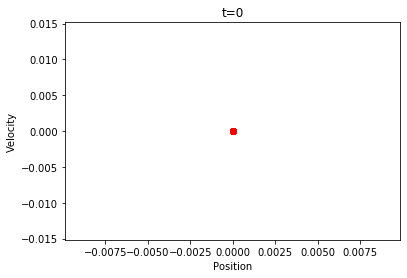

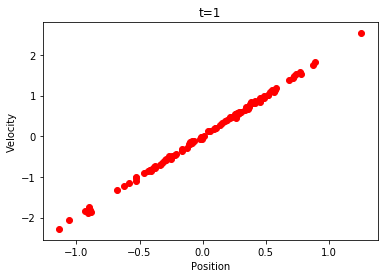

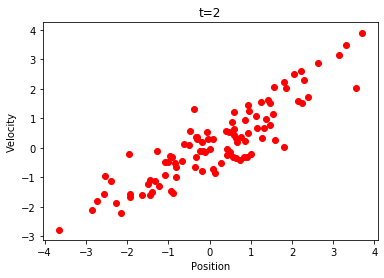

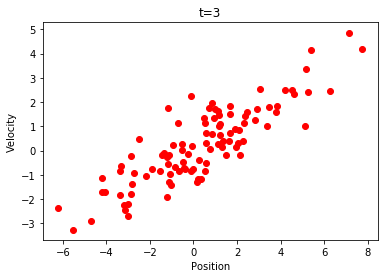

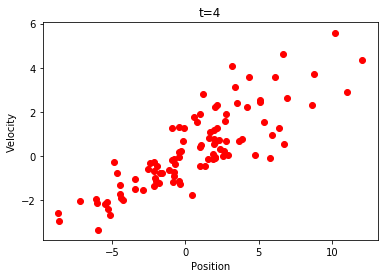

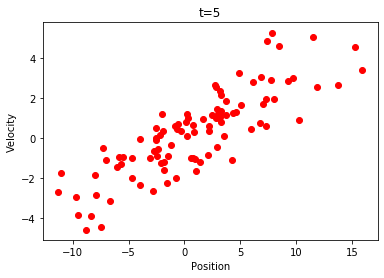

In [5]:
mu = np.array([0,0])                   # mu
A = np.array([[1., 1.],                # noise matrix
             [0., 1.]])
R = np.array([[1/4., 1/2.],            # noise covariance matrix
              [1/2., 1.001]]) 
M = 100                                # number of samples
t = np.linspace(1, 5, 5)               # time t
particles = np.zeros((len(t)+1, 2, M)) # create a t x 2 x M numpy array to store particles

for t in t:
    """
    For every time t, generate M number of particles for the state vector x using the probability
    transition function from problem (a). 
    """
    t = int(t)
    particles[t][0], particles[t][1] = np.dot(A, particles[t-1]) + np.random.multivariate_normal(mu,R,M).T
    
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.scatter(particles[0][0], particles[0][1], color='r')
ax1.set_title("t=0")
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.scatter(particles[1][0], particles[1][1], color='r')
ax2.set_title("t=1")
ax2.set_xlabel('Position')
ax2.set_ylabel('Velocity')

fig3 = plt.figure()
ax3 = fig3.add_subplot()
ax3.scatter(particles[2][0], particles[2][1], color='r')
ax3.set_title("t=2")
ax3.set_xlabel('Position')
ax3.set_ylabel('Velocity')

fig4 = plt.figure()
ax4 = fig4.add_subplot()
ax4.scatter(particles[3][0], particles[3][1], color='r')
ax4.set_title("t=3")
ax4.set_xlabel('Position')
ax4.set_ylabel('Velocity')

fig5 = plt.figure()
ax5 = fig5.add_subplot()
ax5.scatter(particles[4][0], particles[4][1], color='r')
ax5.set_title("t=4")
ax5.set_xlabel('Position')
ax5.set_ylabel('Velocity')

fig6 = plt.figure()
ax6 = fig6.add_subplot()
ax6.scatter(particles[5][0], particles[5][1], color='r')
ax6.set_title("t=5")
ax6.set_xlabel('Position')
ax6.set_ylabel('Velocity')

### (d) For each value of $t$, plot the joint posterior over $x$ and $\dot{x}$ where $x$ is the horizontal axis and $\dot{x}$ is the vertical axis. For each posterior, you are asked to plot an uncertainty ellipse, which is the ellipse of points that are one standard deviation away from the mean.

<ipython-input-2-ed456d6f54c4>:31: RuntimeWarning: invalid value encountered in double_scalars
  pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])


Text(0, 0.5, 'Velocity')

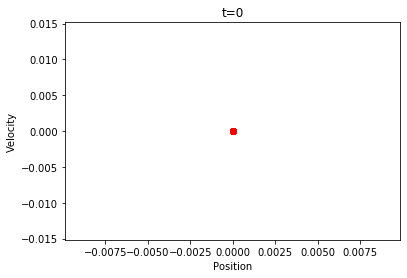

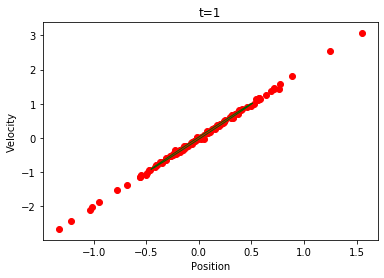

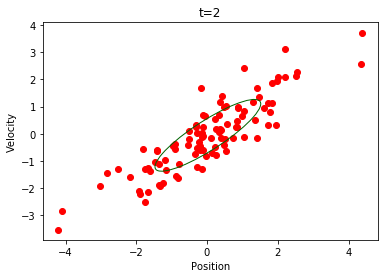

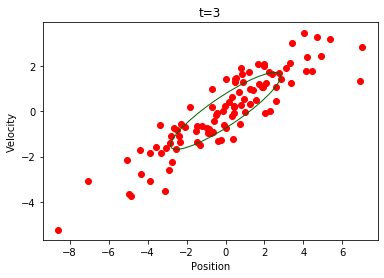

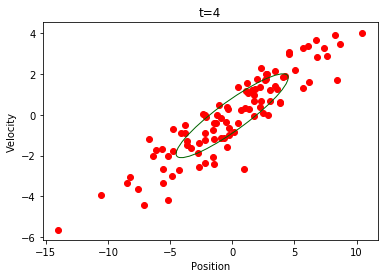

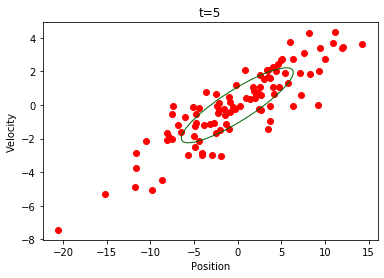

In [16]:
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.scatter(particles[0][0], particles[0][1], color='r')
confidence_ellipse(particles[0][0], particles[0][1], ax1, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax1.set_title("t=0")
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.scatter(particles[1][0], particles[1][1], color='r')
confidence_ellipse(particles[1][0], particles[1][1], ax2, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax2.set_title("t=1")
ax2.set_xlabel('Position')
ax2.set_ylabel('Velocity')

fig3 = plt.figure()
ax3 = fig3.add_subplot()
ax3.scatter(particles[2][0], particles[2][1], color='r')
confidence_ellipse(particles[2][0], particles[2][1], ax3, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax3.set_title("t=2")
ax3.set_xlabel('Position')
ax3.set_ylabel('Velocity')

fig4 = plt.figure()
ax4 = fig4.add_subplot()
ax4.scatter(particles[3][0], particles[3][1], color='r')
confidence_ellipse(particles[3][0], particles[3][1], ax4, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax4.set_title("t=3")
ax4.set_xlabel('Position')
ax4.set_ylabel('Velocity')

fig5 = plt.figure()
ax5 = fig5.add_subplot()
ax5.scatter(particles[4][0], particles[4][1], color='r')
confidence_ellipse(particles[4][0], particles[4][1], ax5, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax5.set_title("t=4")
ax5.set_xlabel('Position')
ax5.set_ylabel('Velocity')

fig6 = plt.figure()
ax6 = fig6.add_subplot()
ax6.scatter(particles[5][0], particles[5][1], color='r')
confidence_ellipse(particles[5][0], particles[5][1], ax6, n_std=1.0,label=r'$1-\sigma$',edgecolor='darkgreen')
ax6.set_title("t=5")
ax6.set_xlabel('Position')
ax6.set_ylabel('Velocity')

### (e) What will happen to the correlation between $x_{t}$ and $\dot{x}_t$ as $t\rightarrow\infty$?

From the figures created in problems (c) and (d), the correlation between $x_t$ and $\dot{x}_t$ would approach 1 as $t$ approaches infinity. 

### We will now add measurements to our particle filter. Suppose at time $𝑡$, we can receive a noisy observation of $x$. In expectation, our sensor measures the true location. However, this measurement is corrupted by Gaussian noise with covariance $\sigma^2=10$. 


### (f) Define the measurement model. Hint: You need to define a matrix $C$ and another matrix $𝑄$.

The measurement function has the form $\mathbf{z}_t = C\mathbf{x}_{t} + v_{t}$. Since the sensor is expected to measure the true location, the observation matrix $C$ should be a square matrix with its dimensions being the same as the amount of states such that it should produce the position and velocity states. The reason why it still gives a velocity state even though it only measures the position is to maintain the number of states in calculation. It will always produce the true velocity without noise since observing a constant zero velocity will cause a significant error if velocity is changing and nonzero. The noise $v_{t}$ can be modeled as a zero-mean Gaussian with variance($Q$). <br> <br>

<center>
    $C \triangleq \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$, <br> <br>
    $p(v_{t}) \sim \mathcal{N}(0, Q)$ <br> 
</center>

Since the sensor only observes the robot's position with some error, the sensor should only report error for the position. Therefore, the covariance $Q$ is: <br> <br>

<center>
$\begin{bmatrix} \sigma^2 & 0 \\ 0 & 0 \end{bmatrix}$. 
</center>
    
Thus, we can find $p(\mathbf{z}_t|\mathbf{x}_t)$ for the particles by drawing random samples of the measurement noise where $p(v_{t}) \sim \mathcal{N}(0, Q)$ and summing it with the product of $C\mathbf{x}_{t}$.

### (g) Implement the measurement update. Suppose at time $t = 5$, we observe a measurement $z =5$. State the parameters of the Gaussian approximation of the particle distribution before and after updating the particle filter. Plot the uncertainty ellipse before and after incorporating the measurement.

In [54]:
mu = np.array([0,0])                   # mu
A = np.array([[1., 1.],                # system matrix
             [0., 1.]])
R = np.array([[1/4., 1/2.],            # system noise covariance matrix
              [1/2., 1.001]])
C = np.array([[1., 0.],                # observation matrix
             [0., 1.]])
Q = np.array([[1., 0.],                # observation noise covariance matrix 
             [0., 0.]])
M = 10                                 # number of samples
t = np.linspace(1, 5, 5)               # time t
particles = np.zeros((len(t)+1, 2, M)) # create a t x 2 x M numpy array to store particles
w = np.zeros((len(t)+1, 2, M))         # create a t x 2 x M weight vector

for t in t:
    """
    For every time t, generate M number of particles for the state vector x using the probability
    transition function from problem (a). 
    """
    t = int(t)
    particles[t][0], particles[t][1] = np.dot(A, particles[t-1]) + np.random.multivariate_normal(mu,R,M).T
    w[t] = np.dot(C,(particles[t][0],particles[t][1])) + np.random.multivariate_normal(mu,Q,M).T
    if t == 1:
        print(w[t])

[[-1.11446053  0.8542303  -0.26679115  2.72085859  1.37436894 -0.73120074
  -0.74833055 -0.3164905   1.19975659 -0.56483974]
 [ 0.53061441 -0.75008723  0.25826162  1.34979528 -0.39219782  1.62944114
  -0.6453791  -0.78806674 -0.31397771  0.02621988]]
